# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
import glob
import pandas as pd
import numpy as np

DATA_FOLDER = 'Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

<span style="color:blue">First we need to to import data into one Dataframe, so we iterate over the different file for the country and inside over the different date and we create a list of DataFrame that will be concatenated using pd.concat. For each 
dataFrame we load in the files we add a info in it named country with the name of the country of which the file give information so that we will be able to know them for the future.<br><br>
Now because of the difference in the way the data has been put in the database of the 3 country, we will need to get 
the info from them separately. So for each country :from the dataframe we take only the line from this country that 
gives the total number of new cases and of death (except for the liberia where there is no total like that for the
new cases so we took all the line related to new cases), we group them by days, sum the total so that we have the 
number of incident by day and next we group them by month so that we can make the mean out of them, we then change 
the name of the column so that it would be the same for every dataframe.<br><br>
Finally once we have the 3 table we just have to append them to have the results.</span>

In [ ]:
listConcat = []

ebolaFolder = DATA_FOLDER + "ebola/"
allFiles = glob.glob(DATA_FOLDER + "ebola/*")

for doc in allFiles:
    if (doc != ".DS_Store") :
        country = doc.split("/")[-1].split("_")[0]
        allCsv = glob.glob(doc + "/*.csv")
        
        for file_ in allCsv:
            newCsv = pd.read_csv(file_)
            newCsv["Country"] = country
            listConcat.append(newCsv)

ebolaFrame = pd.concat(listConcat)
ebolaFrame

In [ ]:
def guineaParseDate(a) :
    return a.split("-")[0] + "-" + a.split("-")[1]

guineaFrame = ebolaFrame[(ebolaFrame.Country == "guinea") & ((ebolaFrame.Description == "Total new cases registered so far") | (ebolaFrame.Description=="Total deaths (confirmed + probables + suspects)"))][["Date", "Country", "Totals"]]
guineaFrame["Totals"] = pd.to_numeric(guineaFrame["Totals"])
guineaFrame = guineaFrame.groupby(["Date", "Country"], as_index=False).sum()
guineaFrame["Date"] = guineaFrame["Date"].map(guineaParseDate)
guineaFrame = guineaFrame.groupby(["Date", "Country"]).mean()

guineaFrame = guineaFrame.rename(columns={"Totals" : "Mean"})
guineaFrame

In [ ]:
def liberiaParseDate(a) :
    monthTry = a.split("/")[0]
    yearTry = a.split("/")[2]
    
    if (len(monthTry) == 1) :
        monthTry = '0' + monthTry
        
    if (len(yearTry) < 4) :
        yearTry = "20" + yearTry
        
    return yearTry + '-' + monthTry 

liberiaFrame = ebolaFrame[(ebolaFrame.Country == "liberia") & ((ebolaFrame.Variable == 'Total death/s in confirmed, \n probable, suspected cases') 
                                                               | (ebolaFrame.Variable == 'Total death/s in confirmed, probable, suspected cases') 
                                                               | (ebolaFrame.Variable == "New Case/s (Suspected)")
                                                              | (ebolaFrame.Variable == "New Case/s (Probable)")
                                                              | (ebolaFrame.Variable == "New case/s (confirmed)"))][["Date","Country","National"]]
liberiaFrame["National"] = pd.to_numeric(liberiaFrame["National"])
liberiaFrame = liberiaFrame.groupby(["Date","Country"], as_index=False).sum()
liberiaFrame["Date"] = liberiaFrame["Date"].map(liberiaParseDate)
liberiaFrame = liberiaFrame.groupby(["Date","Country"]).mean()

liberiaFrame = liberiaFrame.rename(columns={"National" : "Mean"})
liberiaFrame

In [ ]:
slFrame = ebolaFrame[(ebolaFrame.Country == "sl") & ((ebolaFrame.variable.str.startswith('new_')) | (ebolaFrame.variable.str.startswith('death_')))][["date","Country","National"]]
slFrame["National"] = pd.to_numeric(slFrame["National"])
slFrame = slFrame.groupby(["date","Country"], as_index=False).sum()
#the date has the same structure in Sierra Leoneand in guinea so we used the same parser
slFrame["date"] = slFrame["date"].map(guineaParseDate)
slFrame = slFrame.groupby(["date","Country"]).mean()



slFrame = slFrame.rename(columns={"date" : "Date", "National" : "Mean"})

slFrame

In [ ]:
pd.concat([guineaFrame, liberiaFrame, slFrame])



## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

<span style="color:blue">We first need a single DataFrame so we iterate over the file of microbiome but for each dataframe we load we call
the result of the experience by the name of the file so that we can differentiate each result for each element. We 
concatenate all of them in one file that will have 10 columns (1 for the name of what we test, and one for each of
the file).
Now we need to merge the info of all the different lines that have the same product, to do that we will group the lines 
by product and we sum the lines, the reason is because of the way we loaded the data, we now have in each groups 9 
lines with only 1 columns filed that are different for each line and all the rest are NaN value. So when we sum by 
column the sum will add the result for each column ignoring the NaN so we will be left with all the result on 1 line
(or NaN if from the begining we did not have the value).
Next we load the information we want to add in a DataFrame and because the name of the columns is exactly the same 
that the index of each line from the file loaded, we can just iterate over the contant of the new DataFrame to change
the name of the column (just naming the group for MID1, and for the other do the group : the sample)
Next we just have to use fillna to change the NaN to 'unknown'</span>

In [ ]:
listConcat = []

allFiles = glob.glob(DATA_FOLDER + "microbiome/MID*.xls")

for file_ in allFiles:    
    newCsv = pd.read_excel(file_, sheetname='Sheet 1', header=None)
    newCsv = newCsv.rename(columns={0 : "name", 1 : file_.split("/")[-1].split(".")[0]})
    listConcat.append(newCsv)

header = pd.read_excel(DATA_FOLDER + "microbiome/metadata.xls", sheetname='Sheet1', header=None)
headerArray = header.values

RNAFrame = pd.concat(listConcat)
RNAFrame = RNAFrame.groupby("name").sum()
RNAFrame = RNAFrame.rename(columns={headerArray[1][0] : headerArray[1][1]})

for i in range (2, len(headerArray)) :
    RNAFrame = RNAFrame.rename(columns={headerArray[i][0] : headerArray[i][1] + " : " + str(headerArray[i][2])})
    
RNAFrame = RNAFrame.fillna('unknown')
RNAFrame

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [60]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt
HTML(filename=DATA_FOLDER + '/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

<span style="color:blue">Because we just need to create graphics, we only need to load the data of the titanic, take the value we want from it and use the matplotlib to put it in a class. We put `plt.gcf().clear()` at the beggining of each creation of graphic so that the exercises do not cause problems between them.</span>

In [33]:
titanic = pd.read_excel(DATA_FOLDER + "titanic.xls")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


<span style="color:blue">1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. <br><br>
First let's investigate the type and the range for each attribute:</span>

In [34]:
types = titanic.dtypes
names = titanic.columns

for i in range(len(types)) :
    if ((types[i] == np.float64) | (types[i] == np.int64)):
        print("Attribute '" + str(names[i]) + "' is type " + str(types[i]) + " going from " + str(titanic[names[i]].min()) + " to " + str(titanic[names[i]].max()))
    else :
        print("Attribute '" + str(names[i]) + "' is type " + str(types[i]))


Attribute 'pclass' is type int64 going from 1 to 3
Attribute 'survived' is type int64 going from 0 to 1
Attribute 'name' is type object
Attribute 'sex' is type object
Attribute 'age' is type float64 going from 0.1667 to 80.0
Attribute 'sibsp' is type int64 going from 0 to 8
Attribute 'parch' is type int64 going from 0 to 9
Attribute 'ticket' is type object
Attribute 'fare' is type float64 going from 0.0 to 512.3292
Attribute 'cabin' is type object
Attribute 'embarked' is type object
Attribute 'boat' is type object
Attribute 'body' is type float64 going from 1.0 to 328.0
Attribute 'home.dest' is type object


<span style="color:blue"> According to Pandas documentation, "_categoricals are a pandas data type which can take only a limited, and usually fixed, number of possible values_". Thus, we can say the following concerning each attribute:</span>

- _pclass_ is limited to 3 levels corresponding to the three booking class, thus transforming this attribute to a categorical type will save memory. Actually, storing it as a categorical type it will use roughly the length of the dataframe in bytes (as three categories can be encoded over one byte), wheter storing it as an int64 uses roughly 8 times the length of the data in bytes.
- _survived_ -- is limited to 2 levels. For the same reason, we should encoded it as a categorical attribute.
- _name_ -- is by essence unique to any passenger, it is then not an attribute to consider as categorical.
- _sex_ -- is limited to 2 levels, it is then highly recommended to store it as a categorical type
- _age_ -- is a continous attribute by design. We should consider to discretize it first and then encode it as categorical. However, this is usually not advice to do it as we delete information.
- _sibsp_ -- could be encoded as it takes integer values from 0 to 8. This would save memory, and categories can have labels from 0 to 8. However, this loses possibility to apply functions such as _min_, _max_ or _mean_ which are naturally handle by integer values (even though we can give a hierarchy to categorical values, it is not an optimal solution in this case). Thus, we do not recommend to categorized this attribute.
- _parch_  -- same reasoning than the previous atribute.
- _ticket_ -- it would not make that much sense to make categories as there is 939 different ticket numbers (and as many categories). There is no memory to save here and it is more intuitive to keep them as it.
- _fare_ -- could make sense to reprensent it as a categorical value as there is only 281 different values. However, as it has no clear interpretation of what these categories would represent (other than the fare amount), it is more intuitive to keep them as it. Moreover, we would also loose the advantages of using integers.
- _cabin_ -- has 187 levels (with few passengers having to room assigned). It is then possible to categorized with the room as label. However, to be able to manipulate this attribute as str later, we keep it as object.
- _embarked_ -- is definitely categorizable as it is limited to 3 levels.
- _boat_ -- is categorizable as it has only 23 different levels.
- _body_ -- the body is by design attributed indivually to passengers. Thus, it does not make sense to categorized it.
- _home.dest_ -- is also an individual feature which is not suitable to be categorized.

<span style="color:blue"> To summarize the following attributes will be categorized: _pclass_, _survived_, _sex_, _embarked_, and _boat_. Let's check the memory usage of our dataframe before transformation:</span>

In [37]:
titanic.memory_usage()

Index           80
pclass       10472
survived     10472
name         10472
sex          10472
age          10472
sibsp        10472
parch        10472
ticket       10472
fare         10472
cabin        10472
embarked     10472
boat         10472
body         10472
home.dest    10472
dtype: int64

In [38]:
def changeClass(x) :
    return "class " + str(x) + " "

def changeBoat(x):
    return "boat " + str(x) + " "

titanic['pclass'] = titanic['pclass'].map(changeClass, na_action='ignore').astype('category')
titanic['survived'] = titanic['survived'].map({1 : 'survived', 0 : 'dead'}).astype('category')
titanic['sex'] = titanic['sex'].astype('category')
titanic['boat']  = titanic['boat'].map(changeBoat, na_action='ignore').astype('category')
titanic['embarked'] = titanic['embarked'].map({'S' : 'Southampton','Q' : 'Queenstown','C' : 'Cherbourg'}).astype('category')

titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,class 1,survived,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,Southampton,boat 2,NaN,"St Louis, MO"
1,class 1,survived,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,boat 11,NaN,"Montreal, PQ / Chesterville, ON"
2,class 1,dead,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,class 1,dead,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,class 1,dead,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,class 1,survived,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,Southampton,boat 3,NaN,"New York, NY"
6,class 1,survived,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,Southampton,boat 10,NaN,"Hudson, NY"
7,class 1,dead,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,class 1,survived,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,Southampton,boat D,NaN,"Bayside, Queens, NY"
9,class 1,dead,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay"


<span style="color:blue">We can see that we significantly decreased the memory used to stored the attribute we transformed:</span>

In [39]:
titanic.memory_usage()

Index           80
pclass        1413
survived      1405
name         10472
sex           1405
age          10472
sibsp        10472
parch        10472
ticket       10472
fare         10472
cabin        10472
embarked      1413
boat          2805
body         10472
home.dest    10472
dtype: int64

<span style=color:blue>2. Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.<br><br>
We choosed to drop NA values before to plot as they are undetermined.</span>

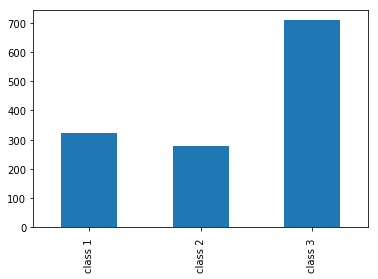

In [42]:
# Travel class 
plt.gcf().clear()
titanic.pclass.dropna().value_counts().sort_index().plot(kind='bar').figure

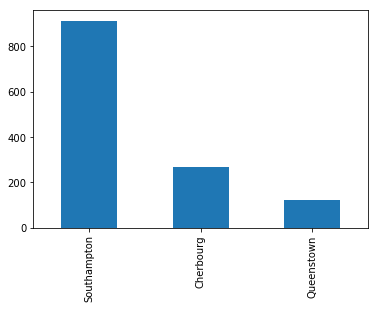

In [43]:
# Embarkation port

plt.gcf().clear()
titanic.embarked.dropna().value_counts().plot(kind='bar').figure

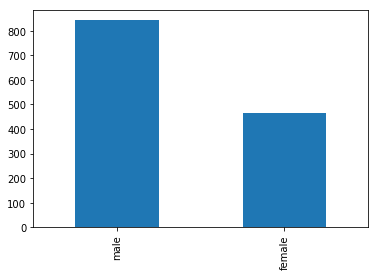

In [44]:
# Sex 

plt.gcf().clear()
mfTitanic = titanic["sex"].dropna().value_counts().plot(kind='bar')
mfTitanic.figure

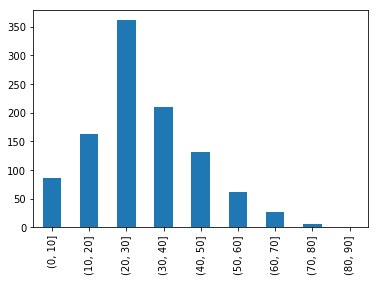

In [61]:
# Age

plt.gcf().clear()
pd.cut(titanic.age.dropna(), [0,10,20,30,40,50,60,70,80,90]).value_counts().sort_index().plot(kind='bar').figure

<span style="color:blue">3. Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.<br><br> From looking at the boat, we consider that the cabin floor is equivalent to the letter on the cabin.<br>We consider that a double on a line of ticket is a person that is assigned two cabin because of buying them with another person so the cabin will be under the person that will use this cabin, so a double will only count for 1 person on a deck.<br>
We consider that in case of a double we cannot know for certitude which one is the room used by the person so we will take one randomly to hope to attain some approximation of the reality.<br>
Using http://www.dummies.com/education/history/titanic-facts-the-layout-of-the-ship/ , we are able to give more accurate name using the letter from the cabin</span>

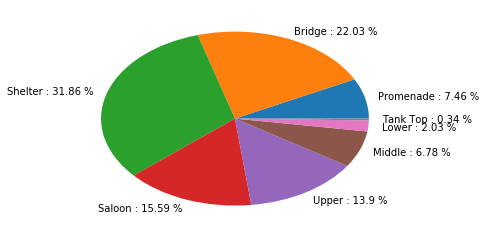

In [62]:
import random

def ticketTofloor(x) :
    split = str(x).split(' ')
    if (len(split) == 1) :
        return split[0][0]
    else :
        return split[random.randint(0, len(split) - 1)][0]

plt.gcf().clear()
mapName = {'A' : 'Promenade',\
           'B' : 'Bridge',\
           'C' : 'Shelter',\
           'D' : 'Saloon',\
           'E' : 'Upper',\
           'F' : 'Middle',\
           'G' : 'Lower',\
           'T' : 'Tank Top'}

cabinTitanic = titanic['cabin'].dropna().map(ticketTofloor, na_action='ignore').value_counts().sort_index()
total = cabinTitanic.values.sum()
plt.pie(cabinTitanic, labels=[mapName[cabinTitanic.index.values[x]] + " : " + str(round(100 * cabinTitanic.values[x] / total, 2)) + " %" for x in range(len(cabinTitanic.index))])
plt.show()

<span style="color:blue">4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.</span>

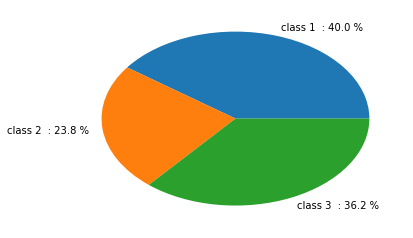

In [63]:
plt.gcf().clear()
classSurvivorTitanic = titanic[titanic.survived == 'survived']['pclass'].dropna().value_counts().sort_index()
total = classSurvivorTitanic.values.sum()
plt.pie(classSurvivorTitanic, labels=[classSurvivorTitanic.index.values[x] + " : " + str(round(100 * classSurvivorTitanic.values[x] / total, 2)) + " %" for x in range(len(classSurvivorTitanic.values))])
plt.show()

<span style="color:blue">5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.</span>

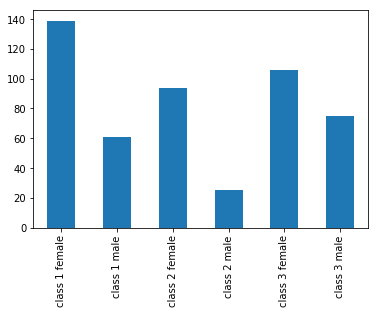

In [72]:
plt.gcf().clear()
survivor = titanic[titanic.survived == 'survived']
(survivor['pclass'].astype('object') + survivor['sex'].astype('object')).value_counts().sort_index().plot.bar().figure
#plt.bar(classSexSurvivorTitanic, labels=[classSexSurvivorTitanic.index.values[x] + " : " + str(round(100 * classSexSurvivorTitanic.values[x] / total, 2)) + " %" for x in range(len(classSexSurvivorTitanic.values))])
#plt.show()

<span style="color:blue">6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.<br><br>
First we find the median, next around the median we create 2 biggest possible groups so that each one has the same
size. We then put the two group together after having change their age from the numerical value to a label for each 
group. After that we just have to put the age class, sex in one columns and count the number of iteration of each 
group and put the result in a dataframe.</span>

In [73]:
# little change so that we have close to the same number on each side (214/213)

median = titanic.age.median()
survivorTitanic = titanic[(titanic.survived == 'survived')]

titanicYoung = pd.concat([(survivorTitanic[survivorTitanic.age < median]), survivorTitanic[(survivorTitanic.age == median)][6:8]])
titanicYoung['age'] = ' young '

titanicOld = pd.concat([survivorTitanic[(survivorTitanic.age > median)], survivorTitanic[(survivorTitanic.age == median)][0:6]])
titanicOld['age'] = ' old '

titanicAgeSplit = pd.concat([titanicYoung, titanicOld])
classSexAgeSurvivorTitanic = (titanicAgeSplit['age'] + titanicAgeSplit['pclass'].astype('object') + titanicAgeSplit['sex'].astype('object')).value_counts().sort_index()

nbpass = classSexAgeSurvivorTitanic.sum()

classSexAgeSurvivorTitanic = classSexAgeSurvivorTitanic.map(lambda x : str(x / nbpass * 100) + " %")
classSexAgeSurvivorTitanic

 old class 1 female       21.07728337236534 %
 old class 1 male         8.899297423887589 %
 old class 2 female      10.304449648711945 %
 old class 2 male         1.639344262295082 %
 old class 3 female       3.747072599531616 %
 old class 3 male         4.215456674473068 %
 young class 1 female     8.899297423887589 %
 young class 1 male        3.51288056206089 %
 young class 2 female    11.241217798594848 %
 young class 2 male       3.747072599531616 %
 young class 3 female    13.114754098360656 %
 young class 3 male       9.601873536299765 %
dtype: object